# The In & Out Strategy 
Developed by the Quantopian & QuantConnect Community. Taken from Peter Guenther's "In Out V7" project and placed in Jupyter Notebook to assist with manual trading. Please take the time to understand the strategy before blindly trading it. 

[QuantConnect Forum](https://www.quantconnect.com/forum/discussion/9597/the-in-amp-out-strategy-continued-from-quantopian/p9)

### Trading the In & Out Strategy
Run the entire script from top to bottom to receive the most recent signal. **Run the entire script by doing a Kernel Restart & Run All.** If there is an "In" signal (1), equity markets are healthy and we enter QQQ. In the event of an "Out" signal (0), exit equities and enter a mixture of bonds and shorts (TLT, IEF, SPDN)

### Requirements
Make sure you have the required imports below. You will need to install yahoo finance package. 

[Install yahoo_fin package](http://theautomatic.net/yahoo_fin-documentation/)

In [3]:
!pip3 install yahoo_fin

In [4]:
import numpy as np
import pandas as pd
import random
from yahoo_fin.stock_info import *
from collections import deque

## Initialize Variables

In [29]:
MRKT = 'QQQ'
PRDC = 'XLI'
METL = 'DBB'
NRES = 'IGE'
DEBT = 'SHY'
USDX = 'UUP'
GOLD = 'GLD'
SLVA = 'SLV'
UTIL = 'XLU'
INDU = PRDC
SPY = 'SPY'
QQQ = MRKT
BOND = 'TLT'

SIGNALS = [PRDC, METL, NRES, USDX, DEBT, MRKT]
FORPAIRS = [GOLD, SLVA, UTIL, INDU]
PAIRLIST = ['G_S', 'U_I']
BASKET_IN = ['QQQ']
BASKET_OUT = ['TLT', 'IEF', 'SPDN']

LOOKBACK = 252*5
INI_WAIT_DAYS = 15
be_in = [1]
global dcount
dcount = 0
global outday
outday = 0

ALL_SYMBOLS = list(SIGNALS + [MRKT] + FORPAIRS + [SPY] + [BOND])

## Gather price data of all symbols

In [61]:
df_data = pd.DataFrame()
for stock_ticker in ALL_SYMBOLS: 
    data = get_data(stock_ticker)
    adj_closed = data['close'][- (LOOKBACK + 4000):-1]
    df_data[stock_ticker] = adj_closed
data = pd.DataFrame(df_data).dropna()

## Moving window of dates

In [64]:
date = []
in_out = []
benchmark = []
bonds = []

def analyze(history):
    global dcount
    global outday
    global date
    global in_out
    global benchmark
    global bonds
    
    history_shift = history.rolling(11, center=True).mean().shift(60)
    returns_sample = (history / history_shift - 1)
    # Reverse code USDX: sort largest changes to bottom
    returns_sample[USDX] = returns_sample[USDX] * (-1)
    # For pairs, take returns differential, reverse coded
    returns_sample['G_S'] = -(returns_sample[GOLD] - returns_sample[SLVA])
    returns_sample['U_I'] = -(returns_sample[UTIL] - returns_sample[INDU])
    # Extreme observations; statistical significance = X% (stat_alpha)
    extreme_b = returns_sample.iloc[-1] < np.nanpercentile(returns_sample, 5, axis=0)

    # Re-assess/disambiguate double-edged signals
    abovemedian = returns_sample.iloc[-1] > np.nanmedian(returns_sample, axis=0)
    ### Interest rate expectations (cost of debt) may increase because the economic outlook improves (showing in rising input prices) = actually not a negative signal
    extreme_b.loc[DEBT] = np.where((extreme_b.loc[DEBT].any()) & (abovemedian[[METL, NRES]].any()), False, extreme_b.loc[DEBT])

    if (extreme_b[SIGNALS + PAIRLIST]).any():
        be_in.append(0)
        outday = dcount
    if dcount >= outday + INI_WAIT_DAYS:
        be_in.append(1)
        
    date.append(history.iloc[-1].name)
    in_out.append(be_in[-1])
    benchmark.append(history['SPY'].iloc[-1])
    bonds.append(history['TLT'].iloc[-1])
    
    dcount += 1

In [65]:
for i in range(-1000, 0): 
    analyze(data[:(i)][-LOOKBACK:])

In [66]:
master = pd.DataFrame({
    'date': date, 
    'in_out': in_out, 
    'SPY': benchmark, 
    'TLT': bonds
})
master = master.set_index('date')

## Here are the signals!

In [67]:
master

,in_out,SPY,TLT
date,,,
2018-04-04,1,263.559998,120.690002
2018-04-05,1,265.640015,119.790001
2018-04-06,0,259.720001,121.099998
2018-04-09,0,261.000000,121.300003
2018-04-10,0,265.149994,121.080002
...,...,...,...
2022-03-16,0,435.619995,132.820007
2022-03-17,0,441.070007,131.830002
2022-03-18,0,444.519989,133.440002


## A visualization of signals produced in the last 1000 days 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3358f9750>,
      dtype=object)

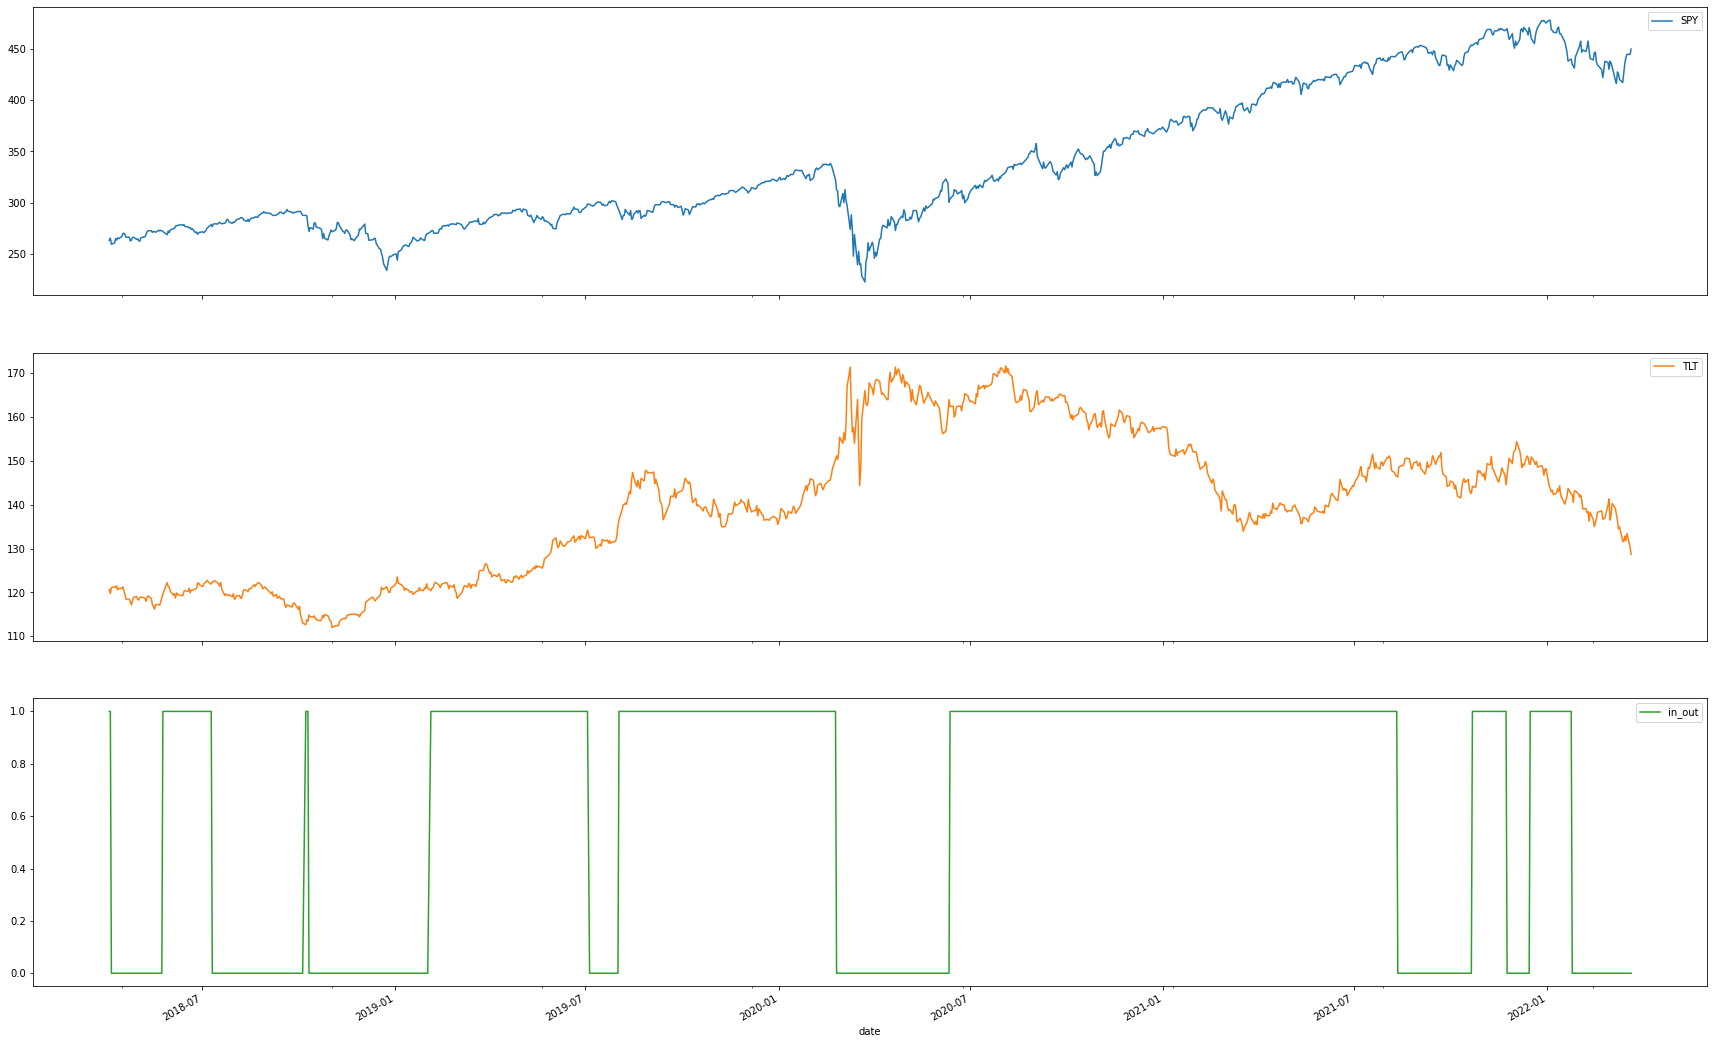

In [68]:
master[['SPY', 'TLT', 'in_out']].plot(subplots=True, figsize=(30,20))

## Visualization of last 100 days 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff335791790>,
      dtype=object)

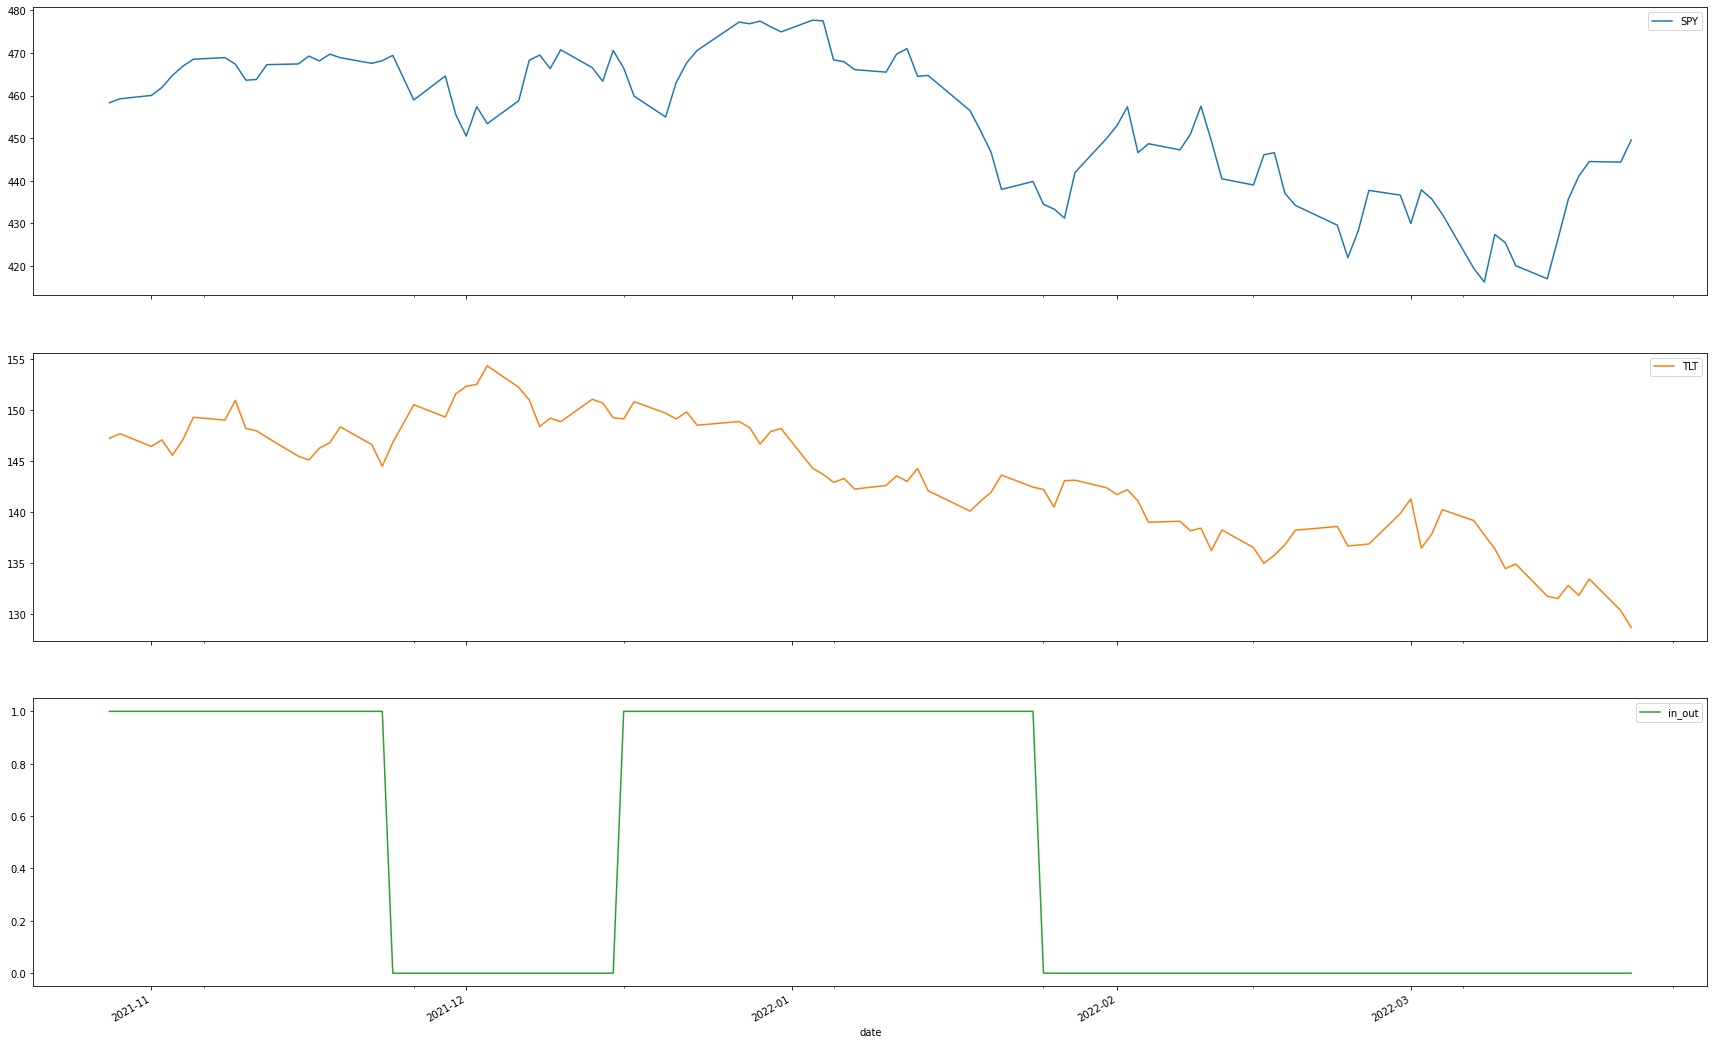

In [69]:
master[-100:][['SPY', 'TLT', 'in_out']].plot(subplots=True, figsize=(30,20))

In [70]:
!git status

fatal: not a git repository (or any of the parent directories): .git
